# VLNCE+EnvDrop AUG
VLNCE: train 301355, val  71280

EnvDrop: train 3000472, val 48001

total train 3301827, val 119281

In [ ]:
import gc
import os,sys
os.chdir("/root/EvoEnc/")
import random
import warnings
from collections import defaultdict
from datetime import datetime
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"
import numpy as np
from PIL import Image
import copy
import torch
from pathlib import Path
from tqdm.notebook import tqdm
from habitat import logger
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.obs_transformers import (
    apply_obs_transforms_batch,
    apply_obs_transforms_obs_space,
    get_active_obs_transforms,
)
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.utils.common import batch_obs

from evoenc.common.aux_losses import AuxLosses
from evoenc.common.base_il_trainer import BaseVLNCETrainer
from evoenc.common.env_utils import construct_envs
from evoenc.common.utils import extract_instruction_tokens
from evoenc.config.default import get_config
def _pause_envs(
    envs_to_pause,
    envs,
    not_done_masks,
    prev_actions,
    batch,
    rgb_frames=None,
):
    # pausing envs with no new episode
    if len(envs_to_pause) > 0:
        state_index = list(range(envs.num_envs))
        for idx in reversed(envs_to_pause):
            state_index.pop(idx)
            envs.pause_at(idx)

        # indexing along the batch dimensions
        not_done_masks = not_done_masks[state_index]
        prev_actions = prev_actions[state_index]

        for k, v in batch.items():
            batch[k] = v[state_index]

        if rgb_frames is not None:
            rgb_frames = [rgb_frames[i] for i in state_index]

    return (
        envs,
        not_done_masks,
        prev_actions,
        batch,
        rgb_frames,
    )

## VLN-CE train

In [ ]:
CONFIG = "/root/EvoEnc/evoenc/config/old/evoenc.yaml"
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/rgb-vlnce/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/depth-vlnce/train")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage3/text-vlnce/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage3/sub-vlnce/train")

os.makedirs(FOLDER_RGB_OUT, exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT, exist_ok=True)
os.makedirs(FOLDER_INST_OUT, exist_ok=True)
os.makedirs(FOLDER_SUB_OUT, exist_ok=True)
total_cnt = 0

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations_raw = copy.deepcopy(observations)
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }
RGB_SIZE = 224
DEPTH_SIZE = 224
LEN = 256
PAD_IDX = 1
SUB_PAD_IDX = 1
SUB_LEN = 50
SUB_NUM = 12
DOWNSAMPLE = 2
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar:
    while collected_eps < config.IL.DAGGER.update_size:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                N = len(ep)
                for step in range(0, N, DOWNSAMPLE):
                    rgb = ep[step][0]["rgb"]
                    depth = ep[step][0]["depth"][..., 0]
                    text = ep[step][0]["instruction"]["text"]
                    sub = ep[step][0]["sub_instruction"]["text"]

                    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(total_cnt)
                    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(total_cnt)
                    inst_path = FOLDER_INST_OUT / "{}.txt".format(total_cnt)
                    sub_path = FOLDER_SUB_OUT / "{}.txt".format(total_cnt)

                    rgb = Image.fromarray(rgb)
                    depth = (depth*10.0*1000).astype(np.uint16) # to meters, and scale 1000 times
                    depth = Image.fromarray(depth)
                    depth = depth.resize((DEPTH_SIZE, DEPTH_SIZE))

                    rgb.save(rgb_path)
                    depth.save(depth_path)
                    with open(inst_path, "w") as f:
                        f.write(text)
                    with open(sub_path, "w") as f:
                        f.write("\n".join(sub))

                    total_cnt+=1
                    

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations_raw[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]
        observations_raw = copy.deepcopy(observations)
        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )


envs.close()
envs = None


In [10]:
# VLN-CE val seen
CONFIG = "/root/EvoEnc/evoenc/config/old/evoenc.yaml"
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/rgb-vlnce/val")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/depth-vlnce/val")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage3/text-vlnce/val")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage3/sub-vlnce/val")

os.makedirs(FOLDER_RGB_OUT, exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT, exist_ok=True)
os.makedirs(FOLDER_INST_OUT, exist_ok=True)
os.makedirs(FOLDER_SUB_OUT, exist_ok=True)
# total_cnt = 0

device = torch.device("cuda")
config = get_config(CONFIG)

config.defrost()
config.TASK_CONFIG.DATASET.SPLIT = "val_unseen"
config.TASK_CONFIG.TASK.NDTW.SPLIT = "val_unseen"
config.freeze()
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations_raw = copy.deepcopy(observations)
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }
RGB_SIZE = 224
DEPTH_SIZE = 224
LEN = 256
PAD_IDX = 1
SUB_PAD_IDX = 1
SUB_LEN = 50
SUB_NUM = 12
DOWNSAMPLE = 2
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar:
    while collected_eps < config.IL.DAGGER.update_size:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                N = len(ep)
                for step in range(0, N, DOWNSAMPLE):
                    rgb = ep[step][0]["rgb"]
                    depth = ep[step][0]["depth"][..., 0]
                    text = ep[step][0]["instruction"]["text"]
                    sub = ep[step][0]["sub_instruction"]["text"]

                    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(total_cnt)
                    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(total_cnt)
                    inst_path = FOLDER_INST_OUT / "{}.txt".format(total_cnt)
                    sub_path = FOLDER_SUB_OUT / "{}.txt".format(total_cnt)

                    rgb = Image.fromarray(rgb)
                    depth = (depth*10.0*1000).astype(np.uint16) # to meters, and scale 1000 times
                    depth = Image.fromarray(depth)
                    depth = depth.resize((DEPTH_SIZE, DEPTH_SIZE))

                    rgb.save(rgb_path)
                    depth.save(depth_path)
                    with open(inst_path, "w") as f:
                        f.write(text)
                    with open(sub_path, "w") as f:
                        f.write("\n".join(sub))

                    total_cnt+=1
                    

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations_raw[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]
        observations_raw = copy.deepcopy(observations)
        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )


envs.close()
envs = None


2024-03-06 11:45:39,976 Initializing dataset VLN-CE-v1


/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AGENT_SPRITE = imageio.imread(
/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AGENT_SPRITE = imageio.imread(
/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AG

  0%|          | 0/10819 [00:00<?, ?it/s]

I0306 11:53:06.195053 945936 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0306 11:53:06.195171 945936 SemanticScene.h:43] Deconstructing SemanticScene
I0306 11:53:06.199462 945936 SceneManager.h:25] Deconstructing SceneManager
I0306 11:53:06.199481 945936 SceneGraph.h:25] Deconstructing SceneGraph
I0306 11:53:06.200536 945936 Sensor.cpp:69] Deconstructing Sensor
I0306 11:53:06.200614 945936 Sensor.cpp:69] Deconstructing Sensor
I0306 11:53:06.222054 945936 Renderer.cpp:71] Deconstructing Renderer
I0306 11:53:06.222075 945936 WindowlessContext.h:17] Deconstructing WindowlessContext
I0306 11:53:06.241377 945936 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/oLBMNvg9in8/oLBMNvg9in8.glb and dataset : default which is currently active dataset.
I0306 11:53:06.246889 945936 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/oLBMNvg9in8/oLBMNvg9in

## AUG

In [ ]:
CONFIG = "/root/EvoEnc/evoenc/config/old/evoenc_aug.yaml"
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/rgb-envdrop/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/depth-envdrop/train")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage3/text-envdrop/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage3/sub-envdrop/train")

os.makedirs(FOLDER_RGB_OUT, exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT, exist_ok=True)
os.makedirs(FOLDER_INST_OUT, exist_ok=True)
os.makedirs(FOLDER_SUB_OUT, exist_ok=True)
total_cnt = 0

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations_raw = copy.deepcopy(observations)
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }
RGB_SIZE = 224
DEPTH_SIZE = 224
LEN = 256
PAD_IDX = 1
SUB_PAD_IDX = 1
SUB_LEN = 50
SUB_NUM = 12
DOWNSAMPLE = 3
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar:
    while collected_eps < config.IL.DAGGER.update_size:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                N = len(ep)
                for step in range(0, N, DOWNSAMPLE):
                    rgb = ep[step][0]["rgb"]
                    depth = ep[step][0]["depth"][..., 0]
                    text = ep[step][0]["instruction"]["text"]
                    sub = ep[step][0]["sub_instruction"]["text"]

                    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(total_cnt)
                    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(total_cnt)
                    inst_path = FOLDER_INST_OUT / "{}.txt".format(total_cnt)
                    sub_path = FOLDER_SUB_OUT / "{}.txt".format(total_cnt)

                    rgb = Image.fromarray(rgb)
                    depth = (depth*10.0*1000).astype(np.uint16) # to meters, and scale 1000 times
                    depth = Image.fromarray(depth)
                    depth = depth.resize((DEPTH_SIZE, DEPTH_SIZE))

                    rgb.save(rgb_path)
                    depth.save(depth_path)
                    with open(inst_path, "w") as f:
                        f.write(text)
                    with open(sub_path, "w") as f:
                        f.write("\n".join(sub))

                    total_cnt+=1
                    

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations_raw[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]
        observations_raw = copy.deepcopy(observations)
        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )

envs.close()
envs = None


In [25]:
# Split to val
import shutil
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-envdrop/train/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-envdrop/train/*.png")))
text_files = sorted(list(FOLDER_RGB_OUT.glob("text-envdrop/train/*.txt")))
sub_files = sorted(list(FOLDER_DEPTH_OUT.glob("sub-envdrop/train/*.txt")))
assert len(rgb_files)==len(depth_files)
assert len(rgb_files)==len(text_files)
assert len(rgb_files)==len(sub_files)
os.makedirs("/root/autodl-tmp/stage3/rgb-envdrop/val", exist_ok=True)
os.makedirs("/root/autodl-tmp/stage3/depth-envdrop/val", exist_ok=True)
os.makedirs("/root/autodl-tmp/stage3/text-envdrop/val", exist_ok=True)
os.makedirs("/root/autodl-tmp/stage3/sub-envdrop/val", exist_ok=True)
val_num = 48000
val_rgb_files = random.sample(rgb_files, val_num)
for rgb_path in tqdm(val_rgb_files):
    rgb_path = str(rgb_path)
    depth_path = rgb_path.replace("rgb-","depth-").replace(".jpg",".png")
    text_path = rgb_path.replace("rgb-","text-").replace(".jpg",".txt")
    sub_path = rgb_path.replace("rgb-","sub-").replace(".jpg",".txt")

    val_rgb_path = rgb_path.replace("/train/","/val/")
    val_depth_path = depth_path.replace("/train/","/val/")
    val_text_path = text_path.replace("/train/","/val/")
    val_sub_path = sub_path.replace("/train/","/val/")

    # print(val_rgb_path, val_depth_path, val_text_path, val_sub_path)
    shutil.move(rgb_path, val_rgb_path)
    shutil.move(depth_path, val_depth_path)
    shutil.move(text_path, val_text_path)
    shutil.move(sub_path, val_sub_path)

  0%|          | 0/48000 [00:00<?, ?it/s]

In [28]:
# Check

3301827
/root/autodl-tmp/stage3/rgb-envdrop/train/391241.jpg /root/autodl-tmp/stage3/depth-envdrop/train/391241.png


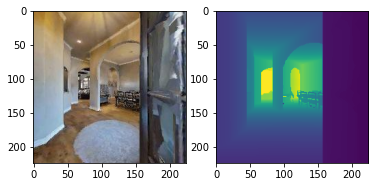

10000
/root/autodl-tmp/stage3/rgb-envdrop/train/2110016.jpg /root/autodl-tmp/stage3/depth-envdrop/train/2110016.png


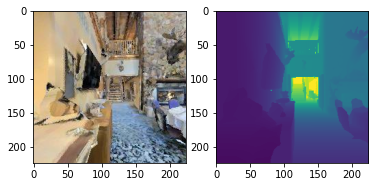

10000
/root/autodl-tmp/stage3/rgb-envdrop/train/2865475.jpg /root/autodl-tmp/stage3/depth-envdrop/train/2865475.png


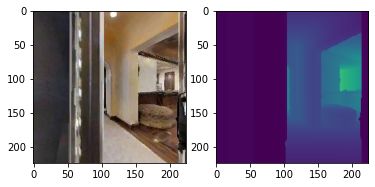

10000
/root/autodl-tmp/stage3/rgb-envdrop/train/134333.jpg /root/autodl-tmp/stage3/depth-envdrop/train/134333.png


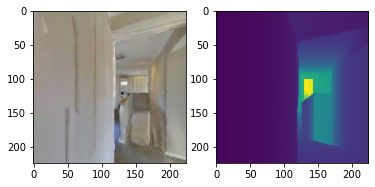

9819
/root/autodl-tmp/stage3/rgb-envdrop/train/1398106.jpg /root/autodl-tmp/stage3/depth-envdrop/train/1398106.png


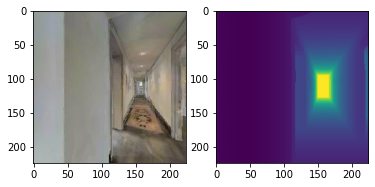

10000
/root/autodl-tmp/stage3/rgb-envdrop/train/2215744.jpg /root/autodl-tmp/stage3/depth-envdrop/train/2215744.png


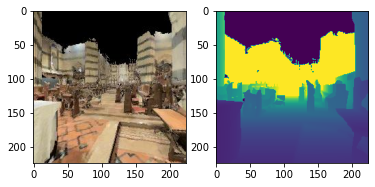

10000
/root/autodl-tmp/stage3/rgb-envdrop/train/2889054.jpg /root/autodl-tmp/stage3/depth-envdrop/train/2889054.png


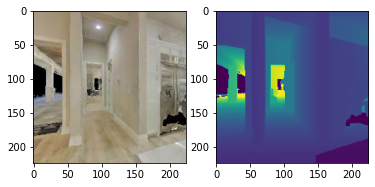

10000
/root/autodl-tmp/stage3/rgb-envdrop/train/1905001.jpg /root/autodl-tmp/stage3/depth-envdrop/train/1905001.png


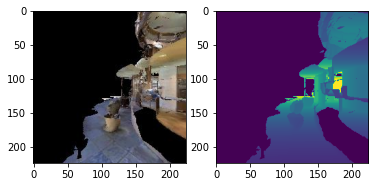

10000
/root/autodl-tmp/stage3/rgb-envdrop/train/116069.jpg /root/autodl-tmp/stage3/depth-envdrop/train/116069.png


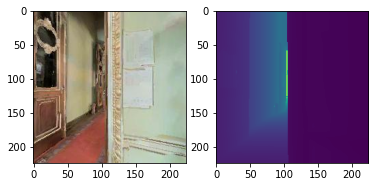

10000
/root/autodl-tmp/stage3/rgb-vlnce/train/17200.jpg /root/autodl-tmp/stage3/depth-vlnce/train/17200.png


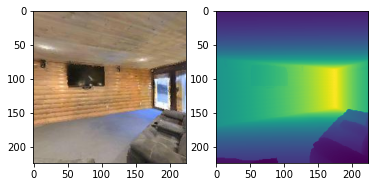

4731
3301827
==========1223615==========
inst: walk forward and turn left . walk forward and stop at the top of the stairs . 
sub: walk forward
and turn left
walk forward
and stop at the top of the stairs
==========2408420==========
inst: walk out of the bedroom and turn right . walk down the hall and stop in front of the couch . 
sub: walk out of the bedroom
and turn right
walk down the hall
and stop in front of the couch
==========2676200==========
inst: walk through the doorway and into the room with the massage beds . walk through the room and into the room with the massage beds . walk into the room with the two beds . 
sub: walk through the doorway and into the room with the massage beds
walk through the room and into the room with the massage beds
walk into the room with the two beds
==========2566251==========
inst: walk into the house and turn right . walk past the red chair and stop in front of the desk . 
sub: walk into the house
and turn right
walk past the red chair
and sto

In [27]:
# print(total_cnt)
import matplotlib.pyplot as plt
# vision train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/train/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/train/*.png")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
for _ in range(10):
    idx = random.randint(0, len(rgb_files)-1)
    rgb = Image.open(rgb_files[idx])
    depth = Image.open(depth_files[idx])
    print(rgb_files[idx], depth_files[idx])
    plt.figure()
    plt.subplot(1,2, 1)
    plt.imshow(rgb)
    plt.subplot(1,2, 2)
    plt.imshow(np.array(depth).astype(float))
    plt.show()
    print(np.array(depth).max())
# text train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
text_files = sorted(list(FOLDER_RGB_OUT.glob("text-*/train/*.txt")))
sub_files = sorted(list(FOLDER_DEPTH_OUT.glob("sub-*/train/*.txt")))
assert len(text_files)==len(sub_files)
print(len(text_files))
for _ in range(10):
    idx = random.randint(0, len(text_files)-1)
    print("=========={}==========".format(idx))
    with open(text_files[idx], "r") as f:
        print("inst: "+f.read())
    with open(sub_files[idx], "r") as f:
        print("sub: "+f.read())

119281
/root/autodl-tmp/stage3/rgb-vlnce/val/50249.jpg /root/autodl-tmp/stage3/depth-vlnce/val/50249.png


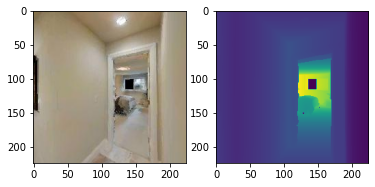

7234
/root/autodl-tmp/stage3/rgb-vlnce/val/17353.jpg /root/autodl-tmp/stage3/depth-vlnce/val/17353.png


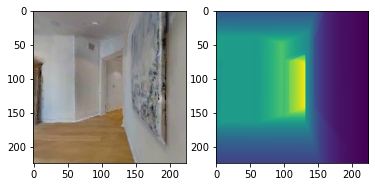

4792
/root/autodl-tmp/stage3/rgb-envdrop/val/860504.jpg /root/autodl-tmp/stage3/depth-envdrop/val/860504.png


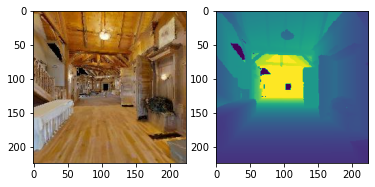

10000
/root/autodl-tmp/stage3/rgb-vlnce/val/48020.jpg /root/autodl-tmp/stage3/depth-vlnce/val/48020.png


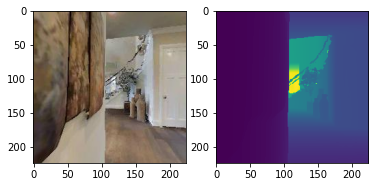

9915
/root/autodl-tmp/stage3/rgb-envdrop/val/2585875.jpg /root/autodl-tmp/stage3/depth-envdrop/val/2585875.png


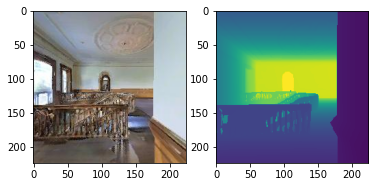

10000
/root/autodl-tmp/stage3/rgb-envdrop/val/1824312.jpg /root/autodl-tmp/stage3/depth-envdrop/val/1824312.png


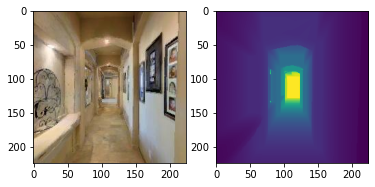

10000
/root/autodl-tmp/stage3/rgb-vlnce/val/62766.jpg /root/autodl-tmp/stage3/depth-vlnce/val/62766.png


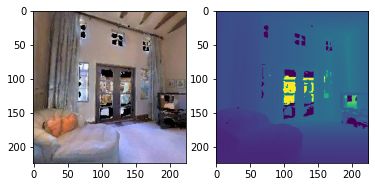

10000
/root/autodl-tmp/stage3/rgb-vlnce/val/49835.jpg /root/autodl-tmp/stage3/depth-vlnce/val/49835.png


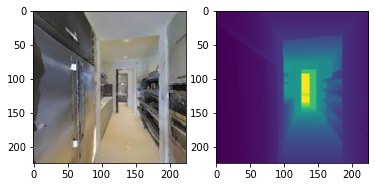

7267
/root/autodl-tmp/stage3/rgb-envdrop/val/922671.jpg /root/autodl-tmp/stage3/depth-envdrop/val/922671.png


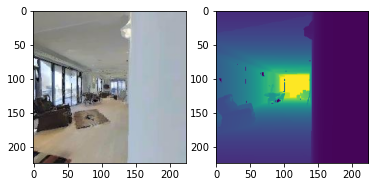

10000
/root/autodl-tmp/stage3/rgb-envdrop/val/2217115.jpg /root/autodl-tmp/stage3/depth-envdrop/val/2217115.png


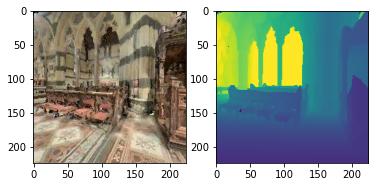

10000
119281
==========81480==========
inst: Turn hard right and exit the exercise area. Walk towards the white sofas. Turn left and walk past the leftmost archway. Wait by the kitchen counter. 
sub: Turn hard right
and exit the exercise area
Walk towards the white sofas
Turn left
and walk past the leftmost archway
Wait by the kitchen counter
==========14516==========
inst: walk past the dining table and into the kitchen . walk past the stove and stop in front of the kitchen . 
sub: walk past the dining table and into the kitchen
walk past the stove
and stop in front of the kitchen
==========33171==========
inst: exit the room and turn right . go down the stairs and wait at the bottom . 
sub: exit the room
and turn right
go down the stairs
and wait at the bottom
==========107436==========
inst: Exit the shower. Go straight to exit the bathroom. Turn right and exit the room. Turn left and then turn right. Wait near the sink. 
sub: Exit the shower
Go straight to exit the bathroom
Turn ri

In [26]:
# print(total_cnt)
import matplotlib.pyplot as plt
# vision train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/val/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/val/*.png")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
for _ in range(10):
    idx = random.randint(0, len(rgb_files)-1)
    rgb = Image.open(rgb_files[idx])
    depth = Image.open(depth_files[idx])
    print(rgb_files[idx], depth_files[idx])
    plt.figure()
    plt.subplot(1,2, 1)
    plt.imshow(rgb)
    plt.subplot(1,2, 2)
    plt.imshow(np.array(depth).astype(float))
    plt.show()
    print(np.array(depth).max())
# text train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
text_files = sorted(list(FOLDER_RGB_OUT.glob("text-*/val/*.txt")))
sub_files = sorted(list(FOLDER_DEPTH_OUT.glob("sub-*/val/*.txt")))
assert len(text_files)==len(sub_files)
print(len(text_files))
for _ in range(10):
    idx = random.randint(0, len(text_files)-1)
    print("=========={}==========".format(idx))
    with open(text_files[idx], "r") as f:
        print("inst: "+f.read())
    with open(sub_files[idx], "r") as f:
        print("sub: "+f.read())

In [30]:
len(text_files)

3301827